In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import numpy as np
import cmocean.cm as cmo
from xgcm import Grid
import matplotlib.gridspec as gridspec

In [2]:
from distributed import Client, progress, LocalCluster
import socket

client = Client(service_kwargs={'dashboard': {'prefix': f'/node/{socket.gethostname()}/8787'}})
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37992,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:44503,Total threads: 1
Dashboard: http://127.0.0.1:41401/status,Memory: 28.00 GiB
Nanny: tcp://127.0.0.1:42018,


In [3]:



def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False,
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    })
    return gridOut

def rho_eos(Tt,Ts,z_r):
    #     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # %
    # % function [rho,bvf]=rho_eos(Tt,Ts,z_r)
    # %
    # % Computes density via Equation Of State (EOS) for seawater.
    # % If so prescribed, non-linear EOS of Jackett and McDougall (1995)
    # % is used.
    # %
    # % Tt potential temperature [deg Celsius].
    # % Ts salinity [PSU].
    # % Tz pressure/depth, [depth in meters and negative].
    # %
    # % K0, K1 and K2 are the pressure polynomial coefficients for secant
    # % bulk modulus, so that
    # %
    # %               bulk = K0 - K1 * z + K2 * z**2 ;
    # %
    # % while rho1 is sea-water density [kg/m^3] at standard pressure
    # % of 1 Atm, so that the density anomaly at in-sity pressure is
    # %
    # %               rho = rho1 / (1 + z / bulk) - 1000
    # %
    # %  Reference:
    # %
    # %  Jackett, D. R. and T. J. McDougall, 1995, Minimal Adjustment of
    # %  Hydrostatic Profiles to Achieve Static Stability, Journ of Atmos.
    # %  and Oceanic Techn., vol. 12, pp. 381-389.
    # %
    # % << This equation of state formulation has been derived by Jackett
    # %    and McDougall (1992), unpublished manuscript, CSIRO, Australia.
    # %    It computes in-situ density anomaly as a function of potential
    # %    temperature (Celsius) relative to the surface, salinity (PSU),
    # %    and depth (meters).  It assumes  no  pressure  variation along
    # %    geopotential  surfaces,  that  is,  depth  and  pressure  are
    # %    interchangeable. >>
    # %                                          John Wilkin, 29 July 92
    # %
    # % Check Values: T=3 C S=35.5 PSU Z=-5000 m rho=1050.3639165364 
    
    import numpy as np
    
    A00=+19092.56;A01=+209.8925;
    A02=-3.041638;A03=-1.852732e-3;A04=-1.361629e-5;A10=104.4077;
    A11=-6.500517;A12=+0.1553190;A13=2.326469e-4;AS0=-5.587545;
    AS1=+0.7390729;AS2=-1.909078e-2;B00=+4.721788e-1;B01=+1.028859e-2;
    B02=-2.512549e-4;B03=-5.939910e-7;B10=-1.571896e-2;B11=-2.598241e-4;
    B12=+7.267926e-6;BS1=+2.042967e-3;E00=+1.045941e-5;E01=-5.782165e-10;
    E02=+1.296821e-7;E10=-2.595994e-7;E11=-1.248266e-9;E12=-3.508914e-9;

    QR=+999.842594;Q01=+6.793952e-2;Q02=-9.095290e-3;
    Q03=+1.001685e-4;Q04=-1.120083e-6;Q05=+6.536332e-9;Q10=+0.824493;
    Q11=-4.08990e-3;Q12=+7.64380e-5;Q13=-8.24670e-7;Q14=+5.38750e-9;
    QS0=-5.72466e-3;QS1=+1.02270e-4;QS2=-1.65460e-6;Q20=+4.8314e-4;
    
    
    sqrtTs=np.sqrt(Ts);

    K0=A00+Tt*(A01+Tt*(A02+Tt*(A03+Tt*A04)))+Ts*(A10+Tt*(A11+Tt*(A12+Tt*A13))+sqrtTs*(AS0+Tt*(AS1+Tt*AS2)));
    K1=B00+Tt*(B01+Tt*(B02+Tt*B03))+Ts*(B10+Tt*(B11+Tt*B12)+sqrtTs*BS1);
    K2=E00+Tt*(E01+Tt*E02)+Ts*(E10+Tt*(E11+Tt*E12));
    rho1=QR+Tt*(Q01+Tt*(Q02+Tt*(Q03+Tt*(Q04+Tt*Q05))))+Ts*(Q10+Tt*(Q11+Tt*(Q12+Tt*(Q13+Tt*Q14)))+sqrtTs*(QS0+Tt*(QS1+Tt*QS2))+Ts*Q20);
    rho=rho1/(1+0.1*z_r/(K0-z_r*(K1-z_r*K2)));
    
    return rho


In [4]:
def load_roms(filename,overlap):
    chunks = {'ocean_time': 1}
    glb_files = sorted(glob(filename))
    
    def preprocessRemoveOverlap(ds):
        '''remove the overlap from each file'''
        return ds.isel(ocean_time = slice(0,-overlap))

    for files in glb_files: 
        print(files)
        
    ds = xr.open_mfdataset(glb_files, chunks=chunks, preprocess=preprocessRemoveOverlap, data_vars='minimal', compat='override', coords='minimal', parallel=False, join='right')
    print('Loading data: OK!')
    return ds




In [5]:
enoi = load_roms(filename='/srv/scratch/z3097808/forecasts_EnOI_TRADobs/output/eac_his_04811.nc',overlap=19)
_4dvar = load_roms(filename='/srv/scratch/z3533092/assimilation_newV2017_traditionalobs/ocean_fwd_001_04367.nc',overlap=7)

/srv/scratch/z3097808/forecasts_EnOI_TRADobs/output/eac_his_04811.nc
Loading data: OK!
/srv/scratch/z3533092/assimilation_newV2017_traditionalobs/ocean_fwd_001_04367.nc
Loading data: OK!


In [6]:
enoi

<xarray.Dataset>
Dimensions:      (tracer: 2, s_rho: 30, s_w: 31, Nuser: 25, eta_rho: 317, xi_rho: 272, eta_u: 317, xi_u: 271, eta_v: 316, xi_v: 272, eta_psi: 316, xi_psi: 271, ocean_time: 24)
Coordinates:
  * s_rho        (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w          (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho      (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho      (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lon_u        (eta_u, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lat_u        (eta_u, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lon_v        (eta_v, xi_v) float64 dask.array<chunksize=(316, 272), meta=np.ndarray>
    lat_v        (eta_v, xi_v) float64 dask.array<chunksize=(316, 272), meta=np.ndarray>
    lon_psi      (eta_psi, xi_psi) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
    lat_psi      (eta_psi, xi_psi) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
  * ocean_time   (ocean_time) datetime64[ns] 2013-03-04 ... 2013-03-07T20:00:00
Dimensions without coordinates: tracer, Nuser, eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/70)
    ntimes       int32 ...
    ndtfast      int32 ...
    dt           float64 ...
    dtfast       float64 ...
    dstart       datetime64[ns] ...
    nHIS         int32 ...
    ...           ...
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 317, 272), meta=np.ndarray>
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 317, 272), meta=np.ndarray>
    shflux       (ocean_time, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 317, 272), meta=np.ndarray>
    ssflux       (ocean_time, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 317, 272), meta=np.ndarray>
    sustr        (ocean_time, eta_u, xi_u) float64 dask.array<chunksize=(1, 317, 271), meta=np.ndarray>
    svstr        (ocean_time, eta_v, xi_v) float64 dask.array<chunksize=(1, 316, 272), meta=np.ndarray>
Attributes: (12/28)
    file:              eac_his.nc
    format:            netCDF-3 classic file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    rst_file:          eac_rst.nc
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -heap-arrays -fp-model precise -ip -O3 -free -free
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.4, Wednesday - September 16, 2020...
    ana_file:          /home/561/cgk561/eac/forecasts_EnOI_TRADobs/include/an...
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

#### data prep

In [7]:
enoi = processROMSGrid(enoi)
grid = makeROMSGridObject(enoi)

_4dvar = processROMSGrid(_4dvar)
grid_4dvar = makeROMSGridObject(_4dvar)


In [8]:
#### Load conversion data

enoi_peke = xr.open_dataarray('enoi_peke_timemean.nc')
enoi_kmke = xr.open_dataarray('enoi_kmke_full.nc')

_4dvar_peke = xr.open_dataarray('4dvar_peke_timemean.nc')
_4dvar_kmke = xr.open_dataarray('4dvar_kmke_full.nc')

In [9]:
enoi

<xarray.Dataset>
Dimensions:      (tracer: 2, s_rho: 30, s_w: 31, Nuser: 25, eta_rho: 317, xi_rho: 272, xi_u: 271, eta_v: 316, ocean_time: 24)
Coordinates: (12/14)
  * s_rho        (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w          (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho      (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho      (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lon_u        (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lat_u        (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    ...           ...
    lon_psi      (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
    lat_psi      (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
  * ocean_time   (ocean_time) datetime64[ns] 2013-03-04 ... 2013-03-07T20:00:00
    z_w          (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 317, 272), meta=np.ndarray>
    z_rho        (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 30, 317, 272), meta=np.ndarray>
    z_rho0       (eta_rho, xi_rho, s_rho) float64 dask.array<chunksize=(317, 272, 30), meta=np.ndarray>
Dimensions without coordinates: tracer, Nuser, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/93)
    ntimes       int32 ...
    ndtfast      int32 ...
    dt           float64 ...
    dtfast       float64 ...
    dstart       datetime64[ns] ...
    nHIS         int32 ...
    ...           ...
    dz_w         (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 317, 272), meta=np.ndarray>
    dz_u         (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 30, 317, 271), meta=np.ndarray>
    dz_w_u       (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 31, 317, 271), meta=np.ndarray>
    dz_v         (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 30, 316, 272), meta=np.ndarray>
    dz_w_v       (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 31, 316, 272), meta=np.ndarray>
    dA           (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
Attributes: (12/28)
    file:              eac_his.nc
    format:            netCDF-3 classic file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    rst_file:          eac_rst.nc
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -heap-arrays -fp-model precise -ip -O3 -free -free
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.4, Wednesday - September 16, 2020...
    ana_file:          /home/561/cgk561/eac/forecasts_EnOI_TRADobs/include/an...
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

In [10]:
#### make means

enoi_peke_0_400=enoi_peke.where(enoi.z_rho0>-400).weighted(weights=enoi.dz.mean(dim='ocean_time')).mean(dim='s_rho').load()
enoi_kmke_0_400=enoi_kmke.where(enoi.z_rho0>-400).weighted(weights=enoi.dz.mean(dim='ocean_time')).mean(dim='s_rho').load()

_4dvar_peke_0_400=_4dvar_peke.where(_4dvar.z_rho0>-400).weighted(weights=_4dvar.dz.mean(dim='ocean_time')).mean(dim='s_rho').load()
_4dvar_kmke_0_400=_4dvar_kmke.where(_4dvar.z_rho0>-400).weighted(weights=_4dvar.dz.mean(dim='ocean_time')).mean(dim='s_rho').load()


In [11]:
enoi_peke_0_400_zav=enoi_peke_0_400.weighted(weights=enoi.dx).sum(dim='xi_rho')/enoi.dx.sum(dim='xi_rho').load()
enoi_kmke_0_400_zav=enoi_kmke_0_400.weighted(weights=enoi.dx).sum(dim='xi_rho')/enoi.dx.sum(dim='xi_rho').load()

_4dvar_peke_0_400_zav=_4dvar_peke_0_400.weighted(weights=_4dvar.dx).sum(dim='xi_rho')/_4dvar.dx.sum(dim='xi_rho').load()
_4dvar_kmke_0_400_zav=_4dvar_kmke_0_400.weighted(weights=_4dvar.dx).sum(dim='xi_rho')/_4dvar.dx.sum(dim='xi_rho').load()

#### averages along entire xi direction

In [12]:

def calc_Z0mean(ds,dz,z_rho0,depth):
    output = (ds.where(z_rho0>depth)*dz.mean(dim='ocean_time')).sum(dim='s_rho')/dz.mean(dim='ocean_time').where(z_rho0>depth).sum(dim='s_rho')
    return output

peke_450_enoi = calc_Z0mean(enoi_peke,enoi.dz,enoi.z_rho0,-450)
kmke_450_enoi = calc_Z0mean(enoi_kmke,enoi.dz,enoi.z_rho0,-450)
peke_450_4dvar = calc_Z0mean(_4dvar_peke,_4dvar.dz,_4dvar.z_rho0,-450)
kmke_450_4dvar = calc_Z0mean(_4dvar_kmke,_4dvar.dz,_4dvar.z_rho0,-450)


/home/z3533092/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


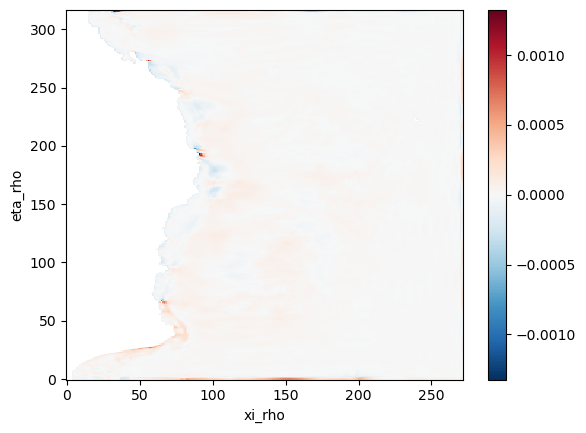

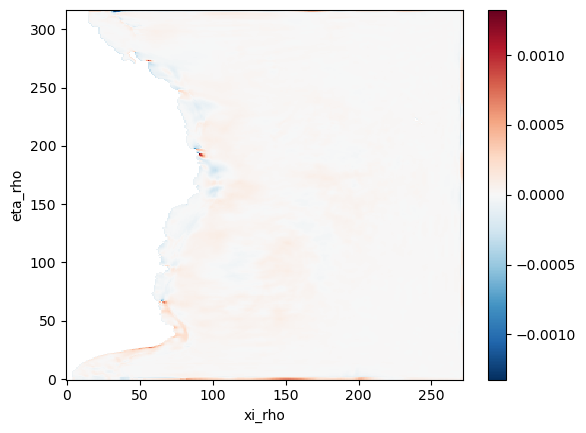

In [13]:
peke_450_enoi.plot()
plt.show()
enoi_peke_0_400.plot()

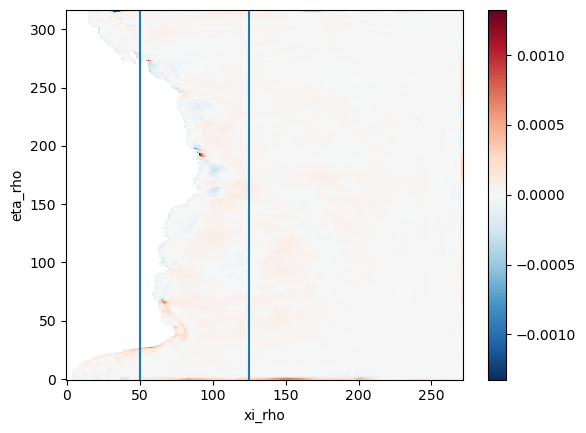

In [34]:
enoi_peke_0_400.plot()
plt.axvline(50)
plt.axvline(125)

In [15]:
# enoi_peke_0_400_zav2=grid.integrate(enoi_peke_0_400,'X')

In [16]:
# enoi_peke_0_400_zav3=(enoi_peke_0_400*(enoi.dx/enoi.dx.sum(dim='xi_rho'))).sum(dim='xi_rho')

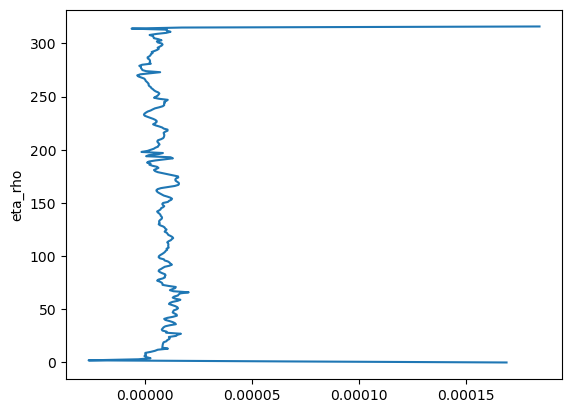

In [17]:
enoi_peke_0_400_zav.plot(y='eta_rho')

In [18]:
# enoi_peke_0_400_zav2.plot(y='eta_rho')

In [19]:
# enoi_peke_0_400_zav3.plot(y='eta_rho')

In [20]:
Coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
CoastHR = cfeature.GSHHSFeature(scale='auto')

Text(0.5, 0, 'Zonally-integrated,$\\overline{0-450m}$ conversion rate (mW/m$^3$)')

<Figure size 640x480 with 0 Axes>

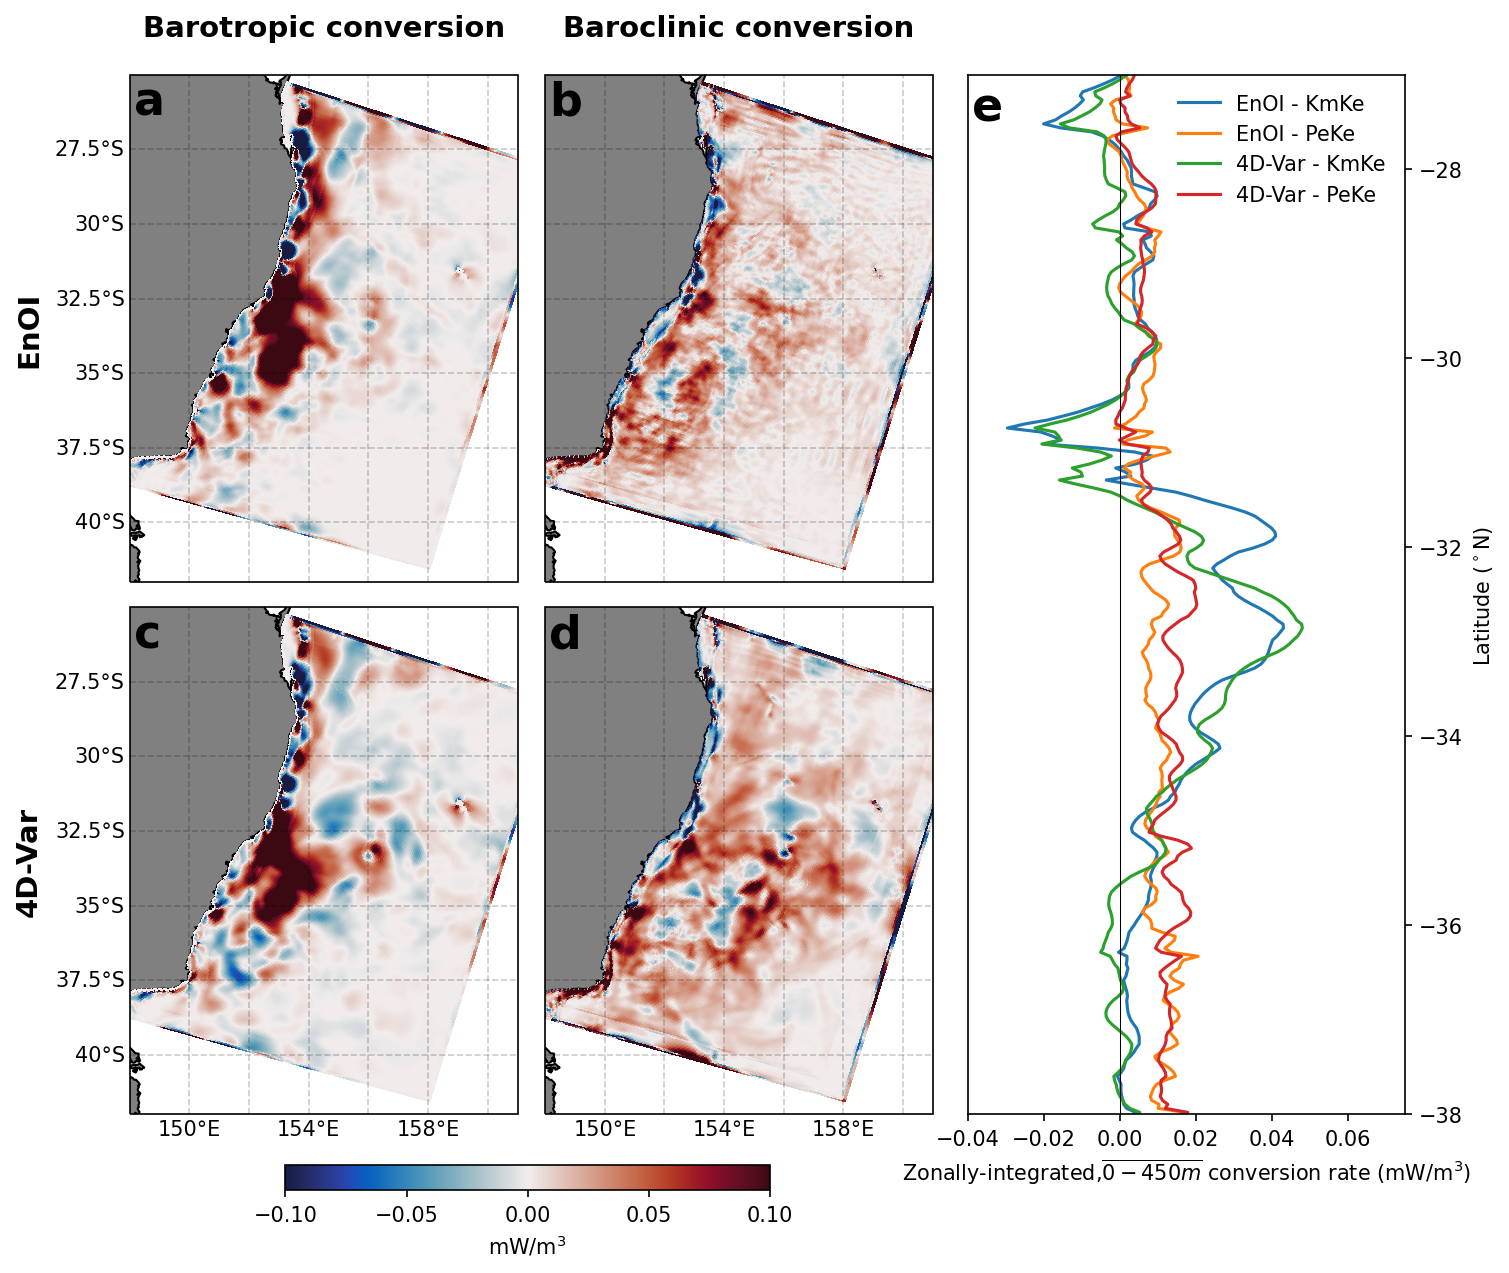

In [33]:



def addSubplot_spatialMap(input,pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    ax.set_title('')
    return gl,im



def addInsetColormap(ax,im,lab):
    cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
    cbar = fig.colorbar(im, cax=cax) 
    cbar.set_label(lab)


# gs to make a 4 row, 7 col plot

plt.cla()
plt.clf()
fig = plt.figure(figsize=[11,9],dpi=150)
ax = None

gs0 = fig.add_gridspec(nrows=1,ncols=2,wspace=0.05, hspace=0.05,width_ratios=[0.65,0.35])

gs00 = gs0[0].subgridspec(2, 2,wspace=0.05, hspace=0.05)
gs01 = gs0[1].subgridspec(1, 1)

scaling=1e3

ax = fig.add_subplot(gs00[0,0], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(kmke_450_enoi*scaling,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
gl.left_labels = True
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Barotropic conversion',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs00[0,1], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(peke_450_enoi*scaling,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Baroclinic conversion',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)


    
ax = fig.add_subplot(gs00[1,0], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(kmke_450_4dvar*scaling,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
gl.left_labels = True
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(-.26, .5, '4D-Var',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
gl.bottom_labels = True

ax = fig.add_subplot(gs00[1,1], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(peke_450_4dvar*scaling,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
gl.bottom_labels = True

cax = inset_axes(ax,
                width="125%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(-.67,-.15, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cbar.set_label('mW/m$^3$')


ax = fig.add_subplot(gs01[0,0])
ax.plot(enoi_kmke_0_400_zav*scaling,enoi.lat_rho.isel(xi_rho=75),label='EnOI - KmKe')
ax.plot(enoi_peke_0_400_zav*scaling,enoi.lat_rho.isel(xi_rho=75),label='EnOI - PeKe')
ax.plot(_4dvar_kmke_0_400_zav*scaling,_4dvar.lat_rho.isel(xi_rho=75),label='4D-Var - KmKe')
ax.plot(_4dvar_peke_0_400_zav*scaling,_4dvar.lat_rho.isel(xi_rho=75),label='4D-Var - PeKe')
ax.axvline(x=0,color='k',linewidth=0.5)
ax.legend(frameon=False)
ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.set_ylim(-38,-27)
ax.set_xlim(-.04,.075)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# ax.set_xlim(-1e4*scaling,1e4*scaling)
ax.set_ylabel('Latitude ($^\circ$N)')
ax.set_xlabel('Zonally-integrated,$\overline{0-450m}$ conversion rate (mW/m$^3$)')

#### average in a band

In [42]:
xi_band=(50,125)
enoi_peke_0_400_zav=enoi_peke_0_400.where((enoi.xi_rho>xi_band[0]) & (enoi.xi_rho<xi_band[1])).weighted(weights=enoi.dx).sum(dim='xi_rho')/enoi.dx.sum(dim='xi_rho').load()
enoi_kmke_0_400_zav=enoi_kmke_0_400.where((enoi.xi_rho>xi_band[0]) & (enoi.xi_rho<xi_band[1])).weighted(weights=enoi.dx).sum(dim='xi_rho')/enoi.dx.sum(dim='xi_rho').load()

_4dvar_peke_0_400_zav=_4dvar_peke_0_400.where((enoi.xi_rho>xi_band[0]) & (enoi.xi_rho<xi_band[1])).weighted(weights=_4dvar.dx).sum(dim='xi_rho')/_4dvar.dx.sum(dim='xi_rho').load()
_4dvar_kmke_0_400_zav=_4dvar_kmke_0_400.where((enoi.xi_rho>xi_band[0]) & (enoi.xi_rho<xi_band[1])).weighted(weights=_4dvar.dx).sum(dim='xi_rho')/_4dvar.dx.sum(dim='xi_rho').load()


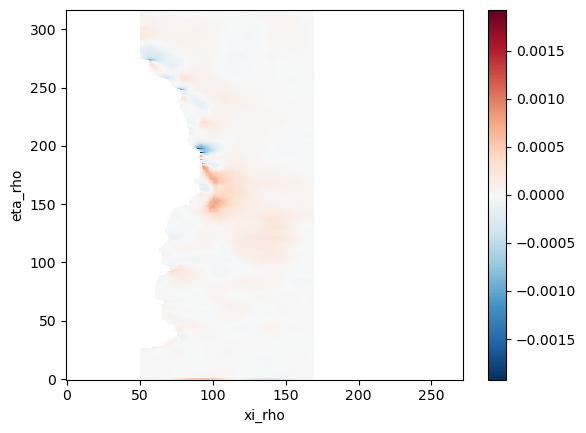

In [53]:
xi_band=(50,170)

enoi_kmke_0_400.where((enoi.xi_rho>xi_band[0]) & (enoi.xi_rho<xi_band[1])).plot()


In [58]:
int(np.mean(xi_band).round())

110

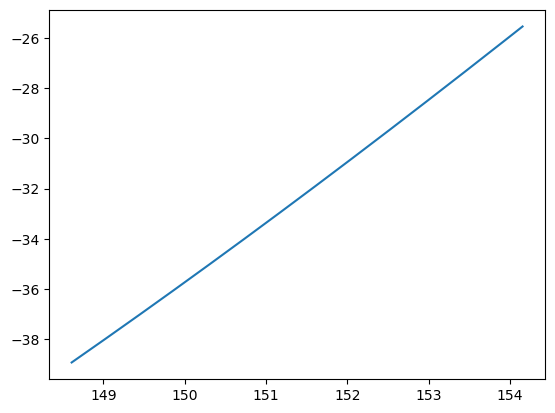

In [48]:
plt.plot(enoi.lon_rho.sel(xi_rho=xi_band[0]),enoi.lat_rho.sel(xi_rho=xi_band[0]))

Text(0.5, 0, 'Zonally-integrated,$\\overline{0-450m}$ conversion rate (mW/m$^3$)')

<Figure size 640x480 with 0 Axes>

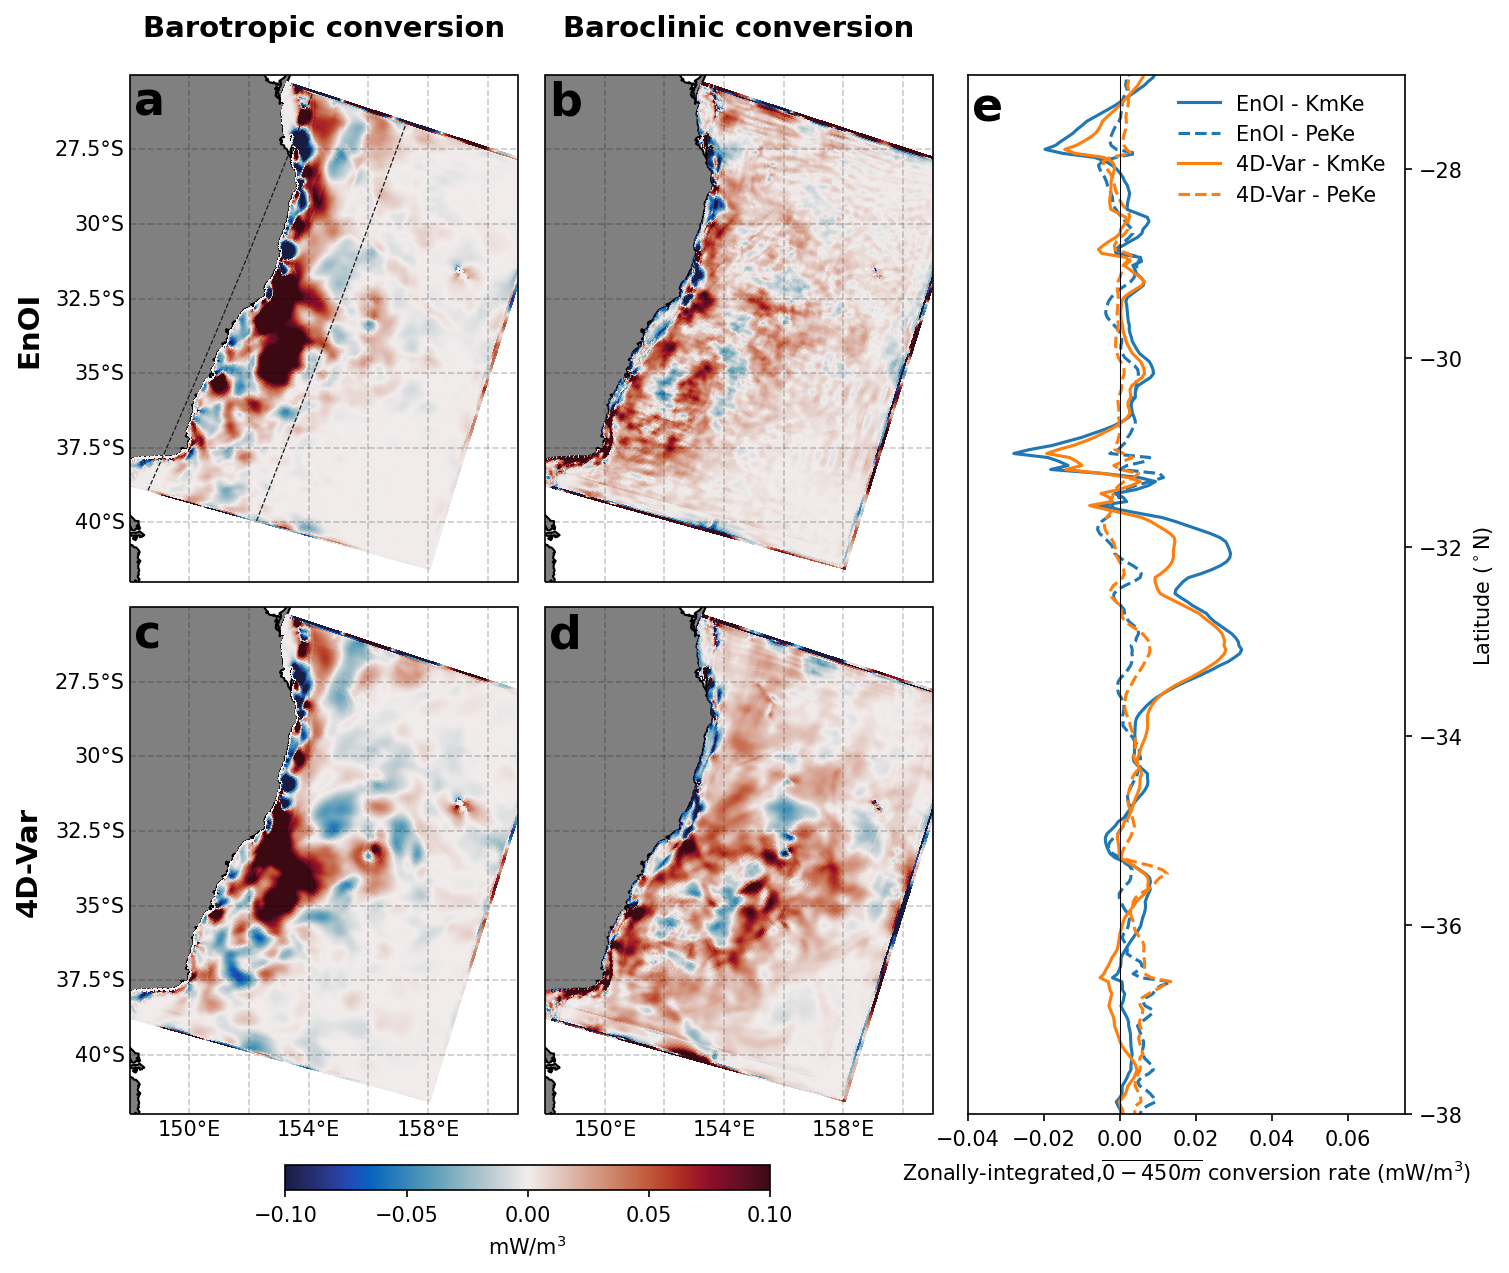

In [60]:



def addSubplot_spatialMap(input,pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    ax.set_title('')
    return gl,im



def addInsetColormap(ax,im,lab):
    cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
    cbar = fig.colorbar(im, cax=cax) 
    cbar.set_label(lab)


# gs to make a 4 row, 7 col plot

plt.cla()
plt.clf()
fig = plt.figure(figsize=[11,9],dpi=150)
ax = None

gs0 = fig.add_gridspec(nrows=1,ncols=2,wspace=0.05, hspace=0.05,width_ratios=[0.65,0.35])

gs00 = gs0[0].subgridspec(2, 2,wspace=0.05, hspace=0.05)
gs01 = gs0[1].subgridspec(1, 1)

scaling=1e3

ax = fig.add_subplot(gs00[0,0], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(kmke_450_enoi*scaling,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
gl.left_labels = True
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Barotropic conversion',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
plt.plot(enoi.lon_rho.sel(xi_rho=xi_band[0]),enoi.lat_rho.sel(xi_rho=xi_band[0]),color='0.1',linewidth=0.6,linestyle='--')
plt.plot(enoi.lon_rho.sel(xi_rho=xi_band[1]),enoi.lat_rho.sel(xi_rho=xi_band[1]),color='0.1',linewidth=0.6,linestyle='--')

ax = fig.add_subplot(gs00[0,1], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(peke_450_enoi*scaling,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Baroclinic conversion',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)


    
ax = fig.add_subplot(gs00[1,0], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(kmke_450_4dvar*scaling,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
gl.left_labels = True
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(-.26, .5, '4D-Var',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
gl.bottom_labels = True

ax = fig.add_subplot(gs00[1,1], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(peke_450_4dvar*scaling,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
gl.bottom_labels = True

cax = inset_axes(ax,
                width="125%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(-.67,-.15, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cbar.set_label('mW/m$^3$')


ax = fig.add_subplot(gs01[0,0])
ax.plot(enoi_kmke_0_400_zav*scaling,enoi.lat_rho.isel(xi_rho=int(np.mean(xi_band).round())),label='EnOI - KmKe',color='C0',linestyle='-')
ax.plot(enoi_peke_0_400_zav*scaling,enoi.lat_rho.isel(xi_rho=int(np.mean(xi_band).round())),label='EnOI - PeKe',color='C0',linestyle='--')
ax.plot(_4dvar_kmke_0_400_zav*scaling,_4dvar.lat_rho.isel(xi_rho=int(np.mean(xi_band).round())),label='4D-Var - KmKe',color='C1',linestyle='-')
ax.plot(_4dvar_peke_0_400_zav*scaling,_4dvar.lat_rho.isel(xi_rho=int(np.mean(xi_band).round())),label='4D-Var - PeKe',color='C1',linestyle='--')
ax.axvline(x=0,color='k',linewidth=0.5)
ax.legend(frameon=False)
ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.set_ylim(-38,-27)
ax.set_xlim(-.04,.075)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# ax.set_xlim(-1e4*scaling,1e4*scaling)
ax.set_ylabel('Latitude ($^\circ$N)')
ax.set_xlabel('Zonally-integrated,$\overline{0-450m}$ conversion rate (mW/m$^3$)')

In [22]:

STOP


NameError: name 'STOP' is not defined

In [ ]:
# calculate peke


def calc_PeKe(input):
    
    g = 9.81
    print('calculate density with custom rho_eos function')
    rho = rho_eos(input.temp,input.salt,input.z_rho)
    print('save rho into ds')          
    input["rho"] = rho # write to ds so we can use the mean function
    input = input.drop_vars(['temp','salt','z_rho'])
     # calculate time-means
    print('calc time means')
    rho_bar = input.rho.mean(dim='ocean_time')
    w_bar = input.w.mean(dim='ocean_time')
     # calculate primes
    print('calc primes')
    w_prime = input.w - w_bar
    rho_prime = input.rho - rho_bar
    input = input.drop_vars(['w','rho'])
    w_prime_rho = grid.interp(w_prime,axis="Z",boundary="fill")
    # plt.figure()
    # w_prime_rho.mean(dim=['ocean_time','s_rho']).plot()
    # plt.show()
    # plt.figure()
    # rho_prime.mean(dim=['ocean_time','s_rho']).plot()
    # plt.show()
    PeKe = -g*rho_prime*w_prime_rho
    return PeKe

In [ ]:

def calc_KmKe(input):

    u = input.u
    v = input.v

    u_bar = u.mean("ocean_time")
    v_bar = v.mean("ocean_time")

    # input.u_bar.attrs["grid"] = grid
    # input.v_bar.attrs["grid"] = grid

    # mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u - u_bar
    v_prime = v - v_bar

    u_bar_rho=grid.interp(u_bar,axis="X",boundary="fill")
    v_bar_rho=grid.interp(v_bar,axis="Y",boundary="fill")

    u_prime_rho=grid.interp(u_prime,axis="X",boundary="fill")
    v_prime_rho=grid.interp(v_prime,axis="Y",boundary="fill")
    
    dudx = grid.derivative(u_bar,'X',boundary='fill')
    dudy = grid.derivative(u_bar_rho,'Y',boundary='fill')
    dvdx = grid.derivative(v_bar_rho,'X',boundary='fill')
    dvdy = grid.derivative(v_bar,'Y',boundary='fill')

    dudy = grid.interp(dudy,axis="Y",boundary="fill")
    dvdx = grid.interp(dvdx,axis="X",boundary="fill")

    rho0 = 1025

    uu = (u_prime_rho*u_prime_rho).mean(dim='ocean_time')
    uv = (u_prime_rho*v_prime_rho).mean(dim='ocean_time')
    vu = (v_prime_rho*u_prime_rho).mean(dim='ocean_time')
    vv = (v_prime_rho*v_prime_rho).mean(dim='ocean_time')


    KmKe = -rho0*(uu*dudx + uv*dudy + vu*dvdx + vv*dvdy)
    return KmKe
